# Tutorial #6: Applying Machine Learning Methods to Temporal Dimensions of EEG Data

This is a short version of Pinar's MVPA tutorial https://neuro.inf.unibe.ch/AlgorithmsNeuroscience/Tutorial_files/ml.html and https://github.com/aath0/AlgorithmsNeuroscience

Author: Pinar Göktepe-Kavis

License: BSD-3-Clause

In this tutorial, we will apply classification on the same EEG data as in the previous cases, [Single-Paricipant Analysis](ApplyingMachineLearningMethods_1.ipynb) and [Group-Level Analysis](ApplyingMachineLearningMethods_2.ipynb), but taking advantage of the temporal dimension of the data.

In the previous tutorials ([Single-Paricipant Analysis](ApplyingMachineLearningMethods_1.ipynb) and [Group-Level Analysis](ApplyingMachineLearningMethods_2.ipynb)) we examined whether it is possible to classify EEG responses to different stimuli, at all. However, the classification was agnostic of time. It just informed that somewhere in the brain, at some point in time, there were differential EEG responses to different stimuli (to check).

Here, we go one step further, and ask the questions:
* (a) Can we classify EEG resposnes to different images?
* (b) When in time is there discriminant EEG activity?

To answer these questions, we will use the same algorithms as in the previous tutorials ([Single-Paricipant Analysis](ApplyingMachineLearningMethods_1.ipynb) and [Group-Level Analysis](ApplyingMachineLearningMethods_2.ipynb))), but this time, we will train one classifier at each time instance and we will evaluate the performance of the model at each time instance in new epochs. 

The function [SlidingEstimator](https://mne.tools/dev/generated/mne.decoding.SlidingEstimator.html) in MNE package is provided for this purpose. This takes the model and optionally a scoring function as parameters to create a time-point by time-point classifier. After having created a sliding estimator, it can be fitted to the data, scored the estimator on each task or made predictions on new epochs.

In [1]:
# To silence the warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore
from mne.decoding import Vectorizer

from os.path import isfile, join
from os import listdir
import numpy as np
import statistics

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

## Analysis on temporal dimensions for each participant separately

1. Prepare data for the analysis

In [15]:
data_folder = '../../datasets/study1_eeg_full/'
files = [data_folder+f for f in listdir(data_folder) if isfile(join(data_folder, f)) and '.DS_Store' not in f]
print(files)
ids = [int(f.split("/")[4].split("-")[0]) for f in files]
print(ids)

['../../datasets/study1_eeg_full/1-P-cleaned.fif', '../../datasets/study1_eeg_full/2-P-cleaned.fif', '../../datasets/study1_eeg_full/3-P-cleaned.fif', '../../datasets/study1_eeg_full/4-P-cleaned.fif']
[1, 2, 3, 4]


In [16]:
epochs = [mne.read_epochs(f, verbose='error') for f in files]
epochs_UN = [e['FU', 'FN'] for e in epochs]
epochs_UP = [e['FU', 'FP'] for e in epochs]
epochs_NP = [e['FN', 'FP'] for e in epochs]
# Dataset with unpleasant and neutral events
data_UN = [e.get_data() for e in epochs_UN]
labels_UN = [e.events[:,-1] for e in epochs_UN]

data_UP = [e.get_data() for e in epochs_UP]
labels_UP = [e.events[:,-1] for e in epochs_UP]

data_NP = [e.get_data() for e in epochs_NP]
labels_NP = [e.events[:,-1] for e in epochs_NP]

2. Train classifiers with sliding window estimator on data of each participant separately and apply 3-fold cross validation.

In [17]:
def applyCrossValidation(data, labels, epochs, ids, classifier):
    CV_score_time = None
    sl = SlidingEstimator(classifier, scoring='accuracy') 
    if np.isfinite(data).all() == True and np.isnan(data).any() == False:
        CV_score_time = cross_val_multiscore(sl, data, labels, cv=3)
        plotCVScores(epochs.times, CV_score_time, ids)
    else:
        print('Input contains NaN or infinity!')
    return CV_score_time

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotCVScores(times, CV_score_time, id=None):
    fig, ax = plt.subplots()
    if id != None:
        fig.suptitle('CV Scores of Participant-'+str(id))
    else:
        fig.suptitle('CV Scores')  
    ax.plot(times, CV_score_time.T)
    plt.xlabel('Time')
    plt.ylabel('CV Accuracy')
    plt.show()

### Classification Between Unplesant and Neutral Events

Participant id: 1


100%|████████████| Fitting SlidingEstimator : 384/384 [00:02<00:00,  169.92it/s]
100%|████████████| Fitting SlidingEstimator : 384/384 [00:02<00:00,  191.09it/s]
100%|████████████| Fitting SlidingEstimator : 384/384 [00:02<00:00,  188.20it/s]


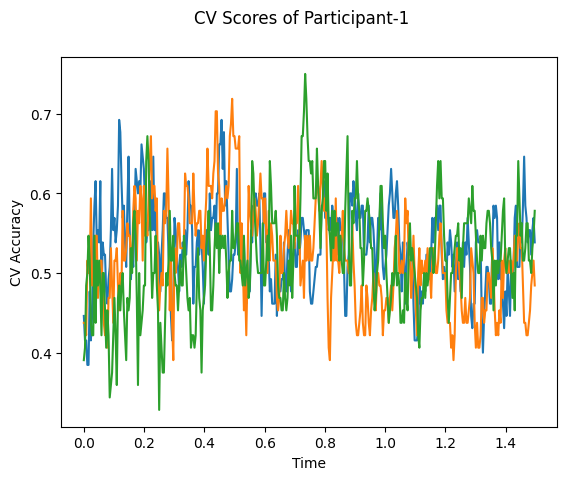

Participant id: 2


100%|████████████| Fitting SlidingEstimator : 384/384 [00:02<00:00,  136.70it/s]
100%|████████████| Fitting SlidingEstimator : 384/384 [00:03<00:00,  127.69it/s]
100%|████████████| Fitting SlidingEstimator : 384/384 [00:03<00:00,  122.85it/s]


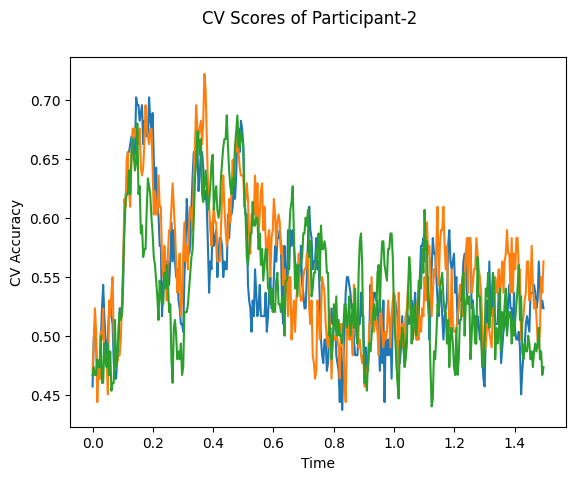

Participant id: 3


100%|████████████| Fitting SlidingEstimator : 384/384 [00:02<00:00,  162.84it/s]
100%|████████████| Fitting SlidingEstimator : 384/384 [00:02<00:00,  186.04it/s]
100%|████████████| Fitting SlidingEstimator : 384/384 [00:02<00:00,  185.29it/s]


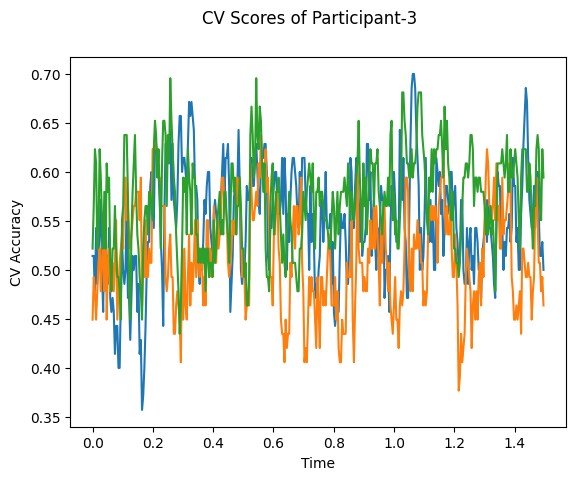

Participant id: 4


100%|████████████| Fitting SlidingEstimator : 384/384 [00:02<00:00,  159.90it/s]
100%|████████████| Fitting SlidingEstimator : 384/384 [00:02<00:00,  159.36it/s]
100%|████████████| Fitting SlidingEstimator : 384/384 [00:02<00:00,  144.51it/s]


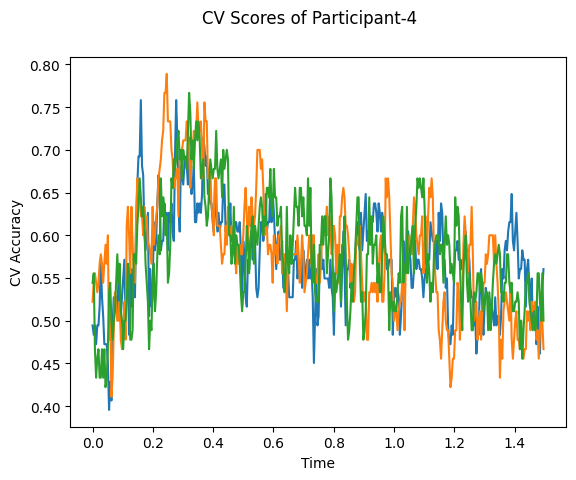

In [19]:
CV_score_time_UN = []
for i in range(len(data_UN)):
    print('Participant id: '+ str(ids[i]))
    clf = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
    CV_score_time_UN.append(applyCrossValidation(data_UN[i], labels_UN[i], epochs_UN[i], ids[i], clf))

In [20]:
def averageCVScores(CV_score_time):
    avg_cv_scores = []
    for cv in CV_score_time:
        avg_scores_tmp = []
        sum_col_wise = cv.sum(axis=0)
        avg_scores_tmp = [s/len(cv) for s in sum_col_wise]
        avg_cv_scores.append(avg_scores_tmp)
    return avg_cv_scores

In [21]:
avg_cv_score_time = averageCVScores(CV_score_time_UN)

The following cell plots the mean and standard deviation of cross validation accuracies of participants.

In [24]:
import pylab, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import ttest_rel, sem

def plot_conditions(data,epochs,labels):

    sns.set(style="white")
    ColorsL = np.array(([228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0]))/256
    col_axes = np.array((82, 82, 82))/256

    al = 0.2
    fig = plt.figure(num=None, figsize=(4, 2), dpi=150)

    
    epochs_mean = np.mean(data, axis = 0)
    epochs_std = sem(data, axis = 0)/2
    plt.axhline(y=0.5, color='b', linestyle='-',label='Chance')
    plt.plot(epochs[0].times, epochs_mean, color = ColorsL[0], linewidth = 2, label = labels)
    plt.fill_between(epochs[0].times, epochs_mean, epochs_mean + epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
    plt.fill_between(epochs[0].times, epochs_mean, epochs_mean - epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
    plt.ylabel('Mean CV Accuracy')
    plt.xlabel('Times')

Mean cross validation accuracy plot below is showing that above chance (50%) accuracy achived at each time points. 

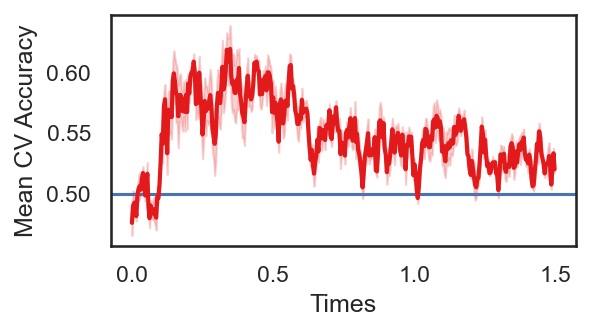

In [25]:
avg_cv_score_time = np.asarray(avg_cv_score_time)
plot_conditions(avg_cv_score_time,epochs_UN, labels_UN)